# Quantum Reservoir Computing for Larmor Precession

 ## Multi-input $(X,Y,Z)$ → Multi-output $(X,Y,Z)$

 We consider a one-qubit physical system undergoing **Larmor precession**.
 The state of the system at time `t` is fully characterized by its Bloch vector:

 $
 \mathbf{y}_t = (x_t, y_t, z_t) \in [-1,1]^3
 $

 The physical dynamics is **linear**:
 $
 \mathbf{y}_{t+1} = R \, \mathbf{y}_t
 $

 where $ R \in SO(3) $ is a rotation matrix determined by the Hamiltonian.

 ---

 ### Goal

 Build a **2-qubit Quantum Reservoir Computer (QRC)** that:

 - takes the full Bloch vector $(x_t,y_t,z_t)$ as input,
 - uses **one qubit as input** and **one qubit as memory**,
 - predicts simultaneously $(x_{t+1},y_{t+1},z_{t+1})$,
 - works **autoregressively**,
 - without any classical normalization or feature engineering.

 ---

 ### Key idea

 The input is already **quantum information**.
 We therefore:

 - inject the Bloch coordinates directly into a quantum state,
 - let a fixed quantum reservoir process this state,
 - and learn only a **linear readout**.


## Why no normalization and no classical encoding?

 In classical reservoir computing, inputs are usually:
 - rescaled,
 - normalized,
 - encoded into some arbitrary feature space.

 Here, this is **unnecessary and undesirable**, because:

 - the Bloch vector components $(x,y,z)$ are already **bounded** in $[-1,1]$,
 - they correspond to **physical expectation values**,
 - they uniquely determine the underlying quantum state.

 By injecting them directly as rotation angles, we:

 - preserve all physical information,
 - avoid artificial distortions,
 - avoid losing correlations between components.

In short: **the data is already quantum, so we keep it quantum**.


## Why can this reservoir learn a linear transformation?

Although the target dynamics is linear in the Bloch vector components $(x_t, y_t, z_t)$,
the **reservoir itself is nonlinear**:

- The input Bloch vector is mapped to a quantum state via rotations.
- The reservoir applies entangling unitary operations on the state.
- The feature vector consists of nonlinear expectation values of various operators.

The crucial point is:

> **A linear readout on a rich nonlinear feature space can represent linear maps.**

### Reservoir learns a nonlinear embedding

In our case, the reservoir effectively **learns a nonlinear mapping** from the Bloch vector to a higher-dimensional feature space:

$
\mathbf{y}_t \mapsto \mathbf{x}_t \in \mathbb{R}^{10}
$

This embedding is nonlinear due to the use of rotations, entanglement, and the nonlinear nature of the expectation values we are measuring. However, despite this nonlinearity in the feature space, the true target map is **linear**:

$
\mathbf{y}_{t+1} = R \mathbf{y}_t
$

where $R$ is a rotation matrix that governs the Larmor precession. The feature space created by the quantum reservoir is sufficiently rich to capture this linear transformation.


In [1]:
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
import sys

ROOT = Path.cwd().parent if Path.cwd().name == "notebooks" else Path.cwd()
sys.path.append(str(ROOT / "src"))

from larmor import *
np.random.seed(0)


In [ ]:
T_TOTAL = 100
T_TRAIN = 60

LAMBDA = 1e-1

omega = 0.9
dt    = 1.0
axis  = (1.0, 1.0, 1.0)

cfg = QRCConfig(scale=np.pi/2, clip_pred=True)

print("T_TOTAL =", T_TOTAL)
print("T_TRAIN =", T_TRAIN)
print("LAMBDA  =", LAMBDA)
print("omega, dt, axis =", omega, dt, axis)
print("cfg =", cfg)


T_TOTAL = 100
T_TRAIN = 60
LAMBDA  = 0.1
omega, dt, axis = 0.9 1.0 (1.0, 1.0, 1.0)
cfg = QRCConfig(scale=1.5707963267948966, clip_pred=True)


In [3]:
states, y_bloch = larmor_dataset(
    T=T_TOTAL + 1,
    dt=dt,
    omega=omega,
    axis=axis,
    psi0=[1,0],  # |0>
)

print("y_bloch shape:", y_bloch.shape)
print("Ranges:")
print("  X:", (y_bloch[:,0].min(), y_bloch[:,0].max()))
print("  Y:", (y_bloch[:,1].min(), y_bloch[:,1].max()))
print("  Z:", (y_bloch[:,2].min(), y_bloch[:,2].max()))

y_bloch shape: (101, 3)
Ranges:
  X: (np.float64(-0.32438674355817726), np.float64(0.9988404197608032))
  Y: (np.float64(-0.33332763480367616), np.float64(0.9679758763851701))
  Z: (np.float64(-0.3168253371193948), np.float64(1.0))


In [4]:
phis   = np.linspace(0, 2*np.pi, 25)
thetas = np.linspace(0, 2*np.pi, 25)

print("Grid size:", len(phis), "x", len(thetas), "=", len(phis)*len(thetas))

Grid size: 25 x 25 = 625


## Reservoir architecture

The reservoir consists of two qubits:

- qubit 0: input qubit,
- qubit 1: memory qubit.

At each time step:

1. the previous input qubit is discarded,
2. the memory qubit is kept via a partial trace,
3. a fresh input state is constructed from $ (x_t, y_t, z_t) $,
4. a fixed 2-qubit unitary is applied,
5. a feature vector is measured.

This implements a quantum dynamical system with fading memory.


## Fixed reservoir unitary

The reservoir unitary is

$
U_{\text{res}}(\phi, \theta)$
=$
\mathrm{CRy}_{0 \to 1}(\phi)
\cdot
(I \otimes R_x(\theta)).
$

Interpretation:

- the memory qubit is rotated around the X axis,
- it is then conditionally rotated around the Y axis depending on the input qubit.

This structure introduces nonlinearity, entanglement, and temporal memory.


## Feature vector

After applying the reservoir unitary, we measure the following observables:

$
\begin{aligned}
\mathbf{x}_t = (&
\langle X_0 \rangle,
\langle Y_0 \rangle,
\langle Z_0 \rangle, \\
&
\langle X_1 \rangle,
\langle Y_1 \rangle,
\langle Z_1 \rangle, \\
&
\langle X_0 X_1 \rangle,
\langle Y_0 Y_1 \rangle,
\langle Z_0 Z_1 \rangle,
1).
\end{aligned}
$

The final constant component is a bias term, which is crucial for stability in autoregressive prediction.


In [5]:
phi_star, theta_star, W_star, train_mse = grid_search(
    phis=phis,
    thetas=thetas,
    y_bloch=y_bloch,
    T_TRAIN=T_TRAIN,
    lam=LAMBDA,
    cfg=cfg,
)

print("Best parameters:")
print("  phi*   =", phi_star)
print("  theta* =", theta_star)
print("  train MSE =", train_mse)
print("W_star shape:", W_star.shape)

Best parameters:
  phi*   = 0.0
  theta* = 1.832595714594046
  train MSE = 0.005692654299298357
W_star shape: (7, 3)


## Training procedure (teacher forcing)

During training, for $ t = 0, \ldots, T_{\text{TRAIN}}-1 $:

- the input is $ \mathbf{u}_t = \mathbf{y}_t $,
- the target is $ \mathbf{y}_{t+1} $.

The readout matrix $ W \in \mathbb{R}^{10 \times 3} $ is obtained by ridge regression:

$
W = (X^\top X + \lambda I)^{-1} X^\top Y,
$

where rows of $ X $ are feature vectors and rows of $ Y $ are target Bloch vectors.

In [6]:
W_star, rho_last, train_mse_check = train_qrc(
    phi=phi_star,
    theta=theta_star,
    y_bloch=y_bloch,
    T_TRAIN=T_TRAIN,
    lam=LAMBDA,
    cfg=cfg,
)

print("Sanity check train MSE:", train_mse_check)
print("rho_last dim:", rho_last.dim)

Sanity check train MSE: 0.005692654299298357
rho_last dim: 4


## Autoregressive prediction

After training, the model is run autonomously.

We initialize the system with the true Bloch vector at time $ T_{\text{TRAIN}} $.
Then, for each subsequent step,

$
\hat{\mathbf{y}}_{t+1} = \mathbf{x}_t W,
\qquad
\mathbf{u}_{t+1} \leftarrow \hat{\mathbf{y}}_{t+1}.
$

This produces a fully autoregressive rollout.

Because the underlying physical dynamics is a rotation
(eigenvalues on the unit circle),
a well-trained model yields stable long-term predictions.


In [7]:
Y_pred = rollout(
    phi=phi_star,
    theta=theta_star,
    W=W_star,
    y_bloch=y_bloch,
    rho_init=rho_last,
    T_TRAIN=T_TRAIN,
    T_TOTAL=T_TOTAL,
    cfg=cfg,
)

print("Y_pred shape:", Y_pred.shape)

Y_pred shape: (40, 3)


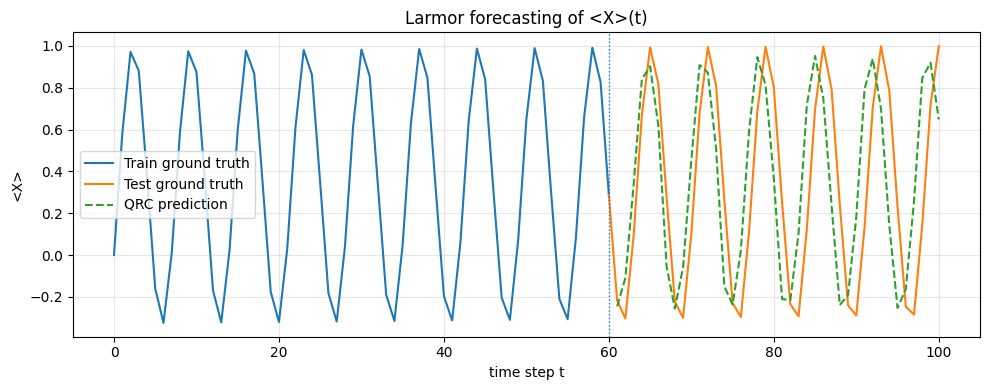

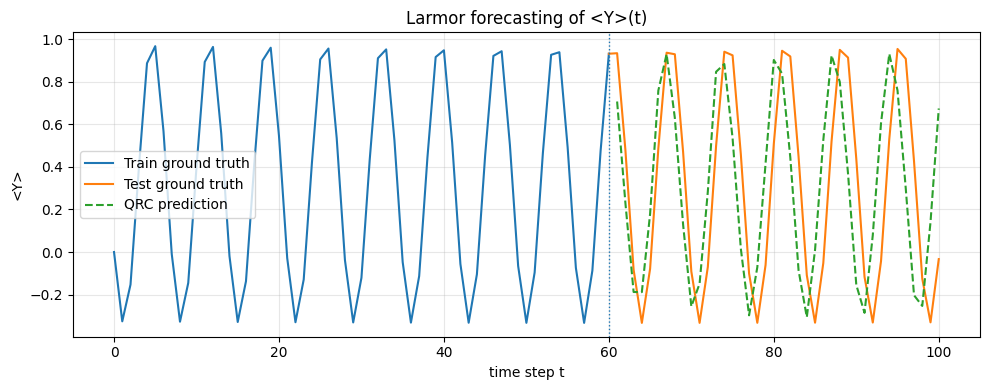

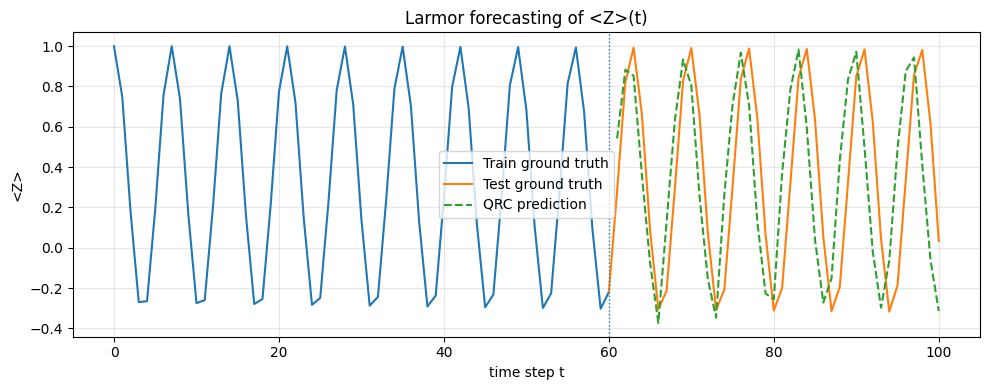

In [8]:
labels = ["X", "Y", "Z"]
t = np.arange(T_TOTAL + 1)

for k, name in enumerate(labels):
    plt.figure(figsize=(10, 4))
    plt.plot(t[:T_TRAIN+1], y_bloch[:T_TRAIN+1, k], label="Train ground truth")
    plt.plot(t[T_TRAIN:],  y_bloch[T_TRAIN:,  k], label="Test ground truth")
    plt.plot(t[T_TRAIN+1:], Y_pred[:, k], "--", label="QRC prediction")
    plt.axvline(T_TRAIN, ls=":", lw=1)
    plt.title(f"Larmor forecasting of <{name}>(t)")
    plt.xlabel("time step t")
    plt.ylabel(f"<{name}>")
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [ ]:
Y_true_test = y_bloch[T_TRAIN+1:T_TOTAL+1]  

abs_err = np.abs(Y_pred - Y_true_test)
rel_err = abs_err / np.maximum(np.abs(Y_true_test), 1e-12)

print("Mean ABS error [X,Y,Z]:", abs_err.mean(axis=0))
print("Mean REL error [X,Y,Z]:", rel_err.mean(axis=0))
print("Mean ABS overall:", abs_err.mean())
print("Mean REL overall:", rel_err.mean())


Mean ABS error [X,Y,Z]: [0.30933438 0.33703605 0.33291969]
Mean REL error [X,Y,Z]: [1.20205738 2.28733184 1.60931459]
Mean ABS overall: 0.3264300355565672
Mean REL overall: 1.6995679364656269


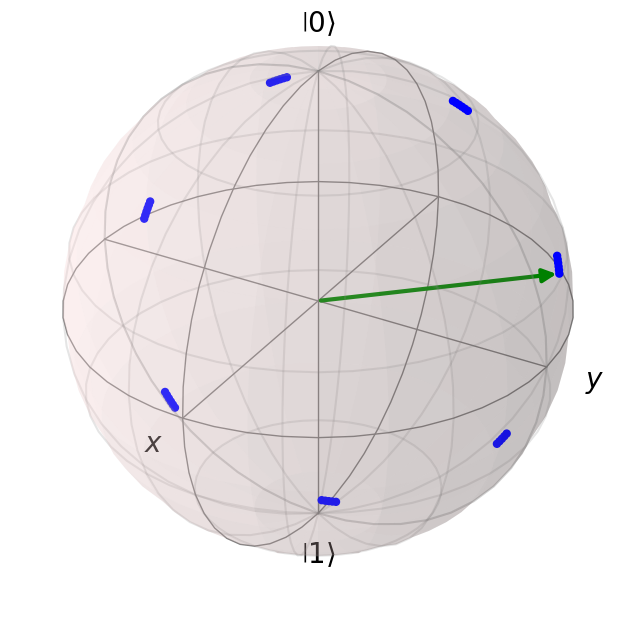

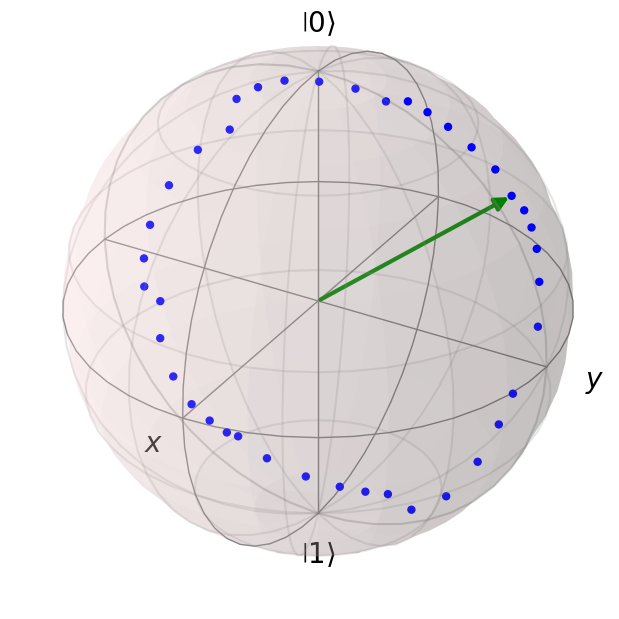

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import Bloch

gt_traj = y_bloch[T_TRAIN+1:T_TOTAL+1, :]  
pred_traj = Y_pred                           

gt_pts = gt_traj.T
pr_pts = pred_traj.T

gt_pts = np.clip(gt_pts, -1.0, 1.0)
pr_pts = np.clip(pr_pts, -1.0, 1.0)

b_gt = Bloch()
b_gt.title = "Ground truth Bloch trajectory"
b_gt.add_points(gt_pts)            
b_gt.add_vectors(gt_pts[:, 0])    

fig1 = plt.figure(figsize=(6, 6))
b_gt.fig = fig1
b_gt.make_sphere()
plt.show()

b_pr = Bloch()
b_pr.title = "QRC-predicted Bloch trajectory"
b_pr.add_points(pr_pts)
b_pr.add_vectors(pr_pts[:, 0])

fig2 = plt.figure(figsize=(6, 6))
b_pr.fig = fig2
b_pr.make_sphere()
plt.show()
